In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
os.chdir("/Users/trinhha/Documents/VU AMSTERDAM/STUDY/Thesis/Code/")
from src.evaluation import compute_fidelity
from src.eda import tsne_scatter
import numpy as np
import seaborn as sns
from scipy.stats import jarque_bera

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'

In [2]:
# Define labels for the metrics to be plotted
metric_labels = {
            "precision": "Precision",
            "recall": "Recall",
            "f1_score": "F1-Score",
            "auc": "AUC",
        }
metric_used = "AUC"

## 0. Best models

In [3]:
# Get the best baseline model
baseline = pd.read_csv("experiments/perf_summary/baseline_val_results.csv")
baseline_model = baseline.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
baseline_test_perf = pd.read_csv("results/metrics/baseline.csv")
baseline_test_perf["version"] = baseline_test_perf["version"].astype(str)
baseline_best = baseline_test_perf[baseline_test_perf["version"].isin(baseline_model)]
baseline_best

,accuracy,precision,recall,f1_score,auc,version,timestamp
24,0.780134,0.472909,0.687794,0.560461,0.81813,202505080012,2025-06-10 00:25:54


In [4]:
# Read the test performance of the DP-SGD models
dpsgd = pd.read_csv("experiments/perf_summary/dpsgd_val_results.csv")
dpsgd_models = dpsgd.query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
dpsgd_test_perf = pd.read_csv("results/metrics/dpsgd.csv")
dpsgd_test_perf["version"] = dpsgd_test_perf["version"].astype(str)
dpsgd_best = dpsgd_test_perf[dpsgd_test_perf["version"].isin(dpsgd_models)].sort_values(by="eps", ascending=True)
display(dpsgd_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp
108,0.742254,0.411054,0.611563,0.491651,0.755500,202506071334,1.0,0.00001,2025-06-10 03:54:53
107,0.763114,0.438011,0.573448,0.496662,0.759364,202506070611,3.0,0.00001,2025-06-10 21:42:21
106,0.751506,0.424439,0.615846,0.502534,0.773462,202506070329,5.0,0.00001,2025-06-10 02:53:26


In [5]:
baseline_params = baseline[baseline.columns[6:-1]]
baseline_params["model"] = "Baseline"
dpsgd_params = dpsgd[dpsgd.columns[6:-1]]
dpsgd_params["model"] = "DP-SGD"

summary_params = pd.concat([baseline_params, dpsgd_params], ignore_index=True).drop(columns=["delta"])
summary_params["epsilon"] = summary_params["epsilon"].apply(lambda x: "$\ " if pd.isna(x) else f"{x:.0f}")
summary_params.sort_values(["model", "epsilon"], inplace=True)
summary_params.set_index(["model", "epsilon", "tuned_by"], inplace=True)
summary_params.reset_index(names=["Model", "eps", "Tuning objective"], inplace=True)
summary_params.fillna("-", inplace=True)
display(summary_params)

# Generate LaTeX table using the requested format
latex_table = r"""\begin{sidewaystable}
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\lambda$ & $\gamma$ & \textbf{Threshold} & $l_2$-norm clip & \textbf{Max Epochs} \\
    \midrule
"""
model = "0"
eps = "0"
def to_latex_sci(x, precision=1):
    """Convert a float to LaTeX scientific notation."""
    if isinstance(x, str) or x == "–":
        return x
    return f"${x:.{precision}e}".replace("e", r" \times 10^{") + "}$"

# Add rows from summary_params
for _, row in summary_params.iterrows():
    if model != row["Model"]:
        latex_table += row["Model"]
    else:
        latex_table += ""
    model = row["Model"]
    if eps != row["eps"]:
        latex_table += " & " + row["eps"].replace("$\ ", "")
    else:
        latex_table += " & "
    eps = row["eps"]
    values = row.values[4:]
    values = [f"{val:.3f}".replace(".000", "") if isinstance(val, (int, float)) and (val >= 0.001 or val == 0) else to_latex_sci(val, precision=3) if isinstance(val, (int, float)) else val for val in values]
    latex_table += f" & {row['Tuning objective'].replace('Score', 'score')} & {row['hidden_dims'].replace('(', '[').replace(',)', ']').replace(')', ']')} & " + " & ".join(values) + r" \\" + "\n"
latex_table += r"""    \bottomrule
    \end{tabular}
\end{sidewaystable}"""
print(latex_table)

,Model,eps,Tuning objective,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,q,l2norm_pct,max_epochs
0,Baseline,$\,Precision,[64],79.0,0.308206,0.042715,0.031488,0.212212,12.687329,0.94,-,-
1,Baseline,$\,Recall,[64],110.0,0.210764,0.050430,0.001106,0.999000,0.034306,0.70,-,-
2,Baseline,$\,F1-Score,[64],83.0,0.000000,0.090339,0.002620,0.999000,0.039524,0.74,-,-
3,Baseline,$\,AUC,"[64, 32]",83.0,0.000795,0.088987,0.001651,0.999000,0.044370,0.70,-,-
4,DP-SGD,1,Precision,[64],114.0,0.207187,0.001527,0.026076,0.304933,10.982668,0.94,80.0,204.0
5,DP-SGD,1,Recall,[64],67.0,0.333740,0.001203,0.082912,0.999000,0.312247,0.70,85.0,421.0
6,DP-SGD,1,F1-Score,[64],91.0,0.281101,0.000158,0.065214,0.988206,0.948025,0.78,87.0,663.0
7,DP-SGD,1,AUC,"[64, 32]",195.0,0.142782,0.001271,0.059730,0.994097,0.618588,0.70,79.0,640.0
8,DP-SGD,3,Precision,"[64, 32]",93.0,0.076595,0.000005,0.100000,0.865558,14.023283,0.94,76.0,700.0
9,DP-SGD,3,Recall,"(64,)",200.0,0.023393,0.002862,0.068990,0.998857,0.197818,0.70,86.0,636.0


\begin{sidewaystable}
    \centering
    \caption{Final hyperparameter configurations by tuning objective}
    \begin{minipage}{\columnwidth} \footnotesize
    \vspace{-2mm}
    Summary of final hyperparameter configurations yielding the highest validation performance based on each tuning objective. Results are reported separately for each model type and privacy budgets ($\varepsilon \in \{1, 3, 5\}$).
    \vspace{2mm}
    \end{minipage}
    \label{tab:final-hyperparams}
    \scriptsize
    \begin{tabular}{llcccccccccc}
    \toprule
    \textbf{Model} & $\varepsilon$ &\textbf{Tuned by} & \textbf{Hidden dimensions} & \textbf{Batch size} & \textbf{Dropout rate} & \textbf{Learning rate} & $\lambda$ & $\gamma$ & \textbf{Threshold} & $l_2$-norm clip & \textbf{Max Epochs} \\
    \midrule
Baseline &  & Precision & [64] & 79 & 0.308 & 0.043 & 0.031 & 0.212 & 12.687 & 0.940 & - & - \\
 &  & Recall & [64] & 110 & 0.211 & 0.050 & 0.001 & 0.999 & 0.034 & 0.700 & - & - \\
 &  & F1-score & [64] & 83

## 1. Performance trade-off

### a. Test set performance (with fixed seed)

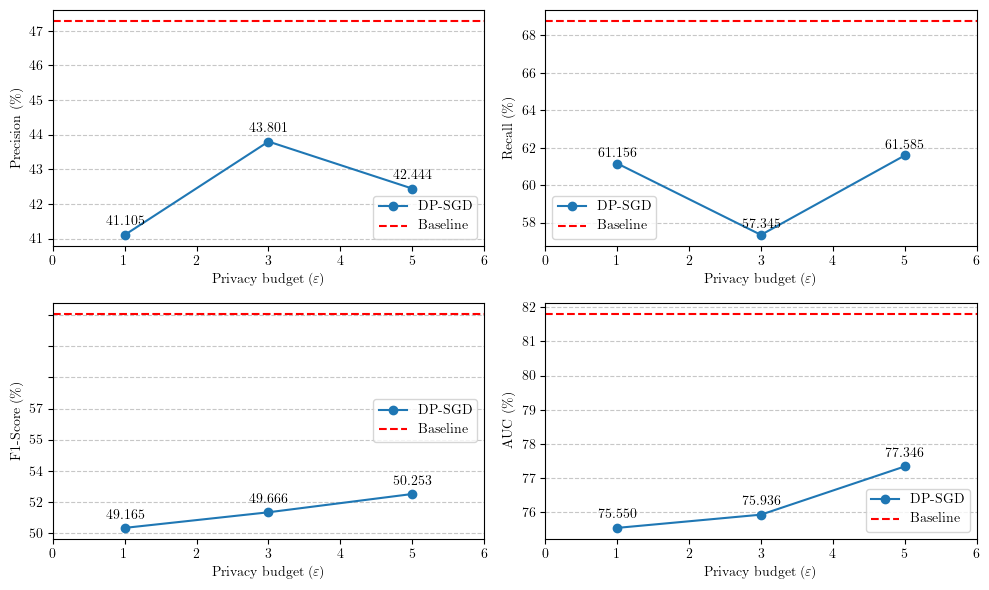

In [6]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metric_labels.keys()):
    ax = axes[i]
    ax.plot(dpsgd_best['eps'], dpsgd_best[metric], marker='o', label='DP-SGD')
    # Add baseline data label
    ax.axhline(y=baseline_best[metric].tolist()[0], color='red', linestyle='--', label='Baseline')
    # Set x axis from 0 to 6
    ax.set_xlim(0, 6)
    # Add data labels
    for j, v in enumerate(dpsgd_best[metric]):
        ax.text(dpsgd_best['eps'].iloc[j], v + 0.002, f"{v * 100:.3f}", ha='center', va='bottom')
    ax.legend(loc='best')
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # Set y ticks to percentage
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(v * 100)}" for v in yticks])
    # Set y label
    ax.set_ylabel(metric_labels[metric] + " (\%)")
    # Set x label
    ax.set_xlabel(r'Privacy budget ($\varepsilon$)')

plt.tight_layout()
plt.savefig("results/figures/performance_comparison.png", dpi=300)
plt.show()

### b. Test set performance (with multiple runs)

In [ ]:
# Gather the performance metrics and perform normality test

model_list = {"Baseline": f"baseline/{m}" for m in baseline_best["version"].tolist()}

model_list.update({r"$\varepsilon=$" + f"{row['eps']:.0f}": f"dpsgd/{row['version']}" for i, row in dpsgd_best.iterrows()})

perf_stats = pd.DataFrame()
for key, value in model_list.items():
    print("Model:", key)
    perf = pd.read_csv(f"results/stats_eval/{value}.csv")[:50]
    perf.insert(0, "Model", key)

    # Perform normality test
    for i, metric in enumerate(perf.columns.tolist()[1:]):
        if len(perf[perf[metric].notnull()]) > 0:
            stat, p = jarque_bera(perf[metric])
            print(f"Jarque-Bera test for metric {metric}: stat={stat:.4f}, p={p:.4g}")
            if p > 0.05:
                print("Data appears to be normally distributed.")
            else:
                print("Data does not appear to be normally distributed.")

    perf_stats = pd.concat([perf_stats, perf], ignore_index=True)
    

Model: Baseline
Jarque-Bera test for metric Precision: stat=1.1131, p=0.5732
Data appears to be normally distributed.
Jarque-Bera test for metric Recall: stat=1.1131, p=0.5732
Data appears to be normally distributed.
Jarque-Bera test for metric F1-Score: stat=1.1131, p=0.5732
Data appears to be normally distributed.
Jarque-Bera test for metric AUC: stat=5.3289, p=0.06964
Data appears to be normally distributed.
Model: $\varepsilon=$1
Jarque-Bera test for metric Precision: stat=0.5388, p=0.7638
Data appears to be normally distributed.
Jarque-Bera test for metric Recall: stat=0.5388, p=0.7638
Data appears to be normally distributed.
Jarque-Bera test for metric F1-Score: stat=0.5388, p=0.7638
Data appears to be normally distributed.
Jarque-Bera test for metric AUC: stat=0.4402, p=0.8024
Data appears to be normally distributed.
Model: $\varepsilon=$3
Model: $\varepsilon=$5


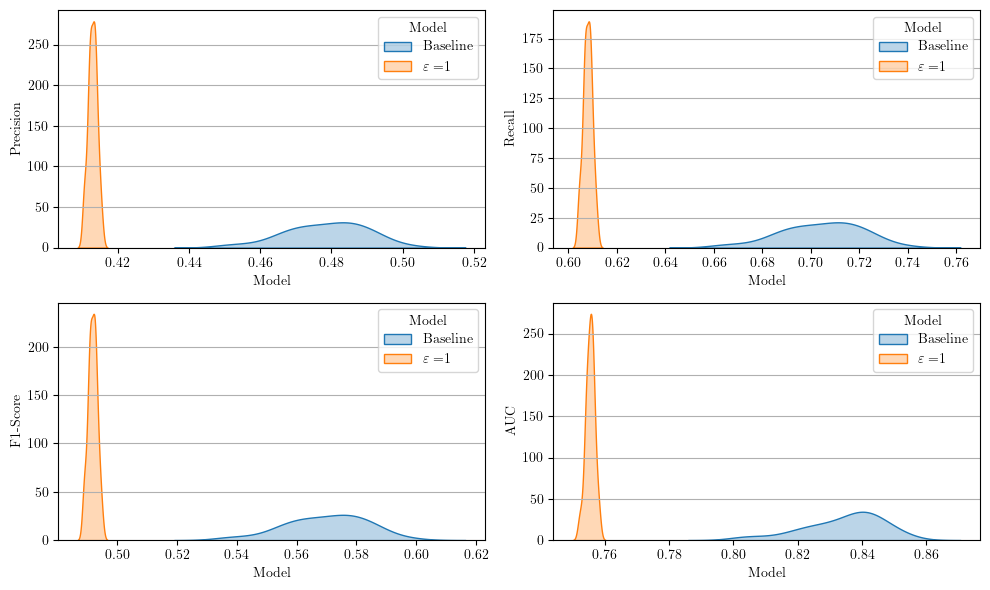

In [15]:
# KDE plot

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(perf_stats.columns.tolist()[1:]):
    ax = axes[i]
    sns.kdeplot(data=perf_stats, x=metric, hue="Model", ax=axes[i],
            fill=True, common_norm=False, alpha=0.3, linewidth=1)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

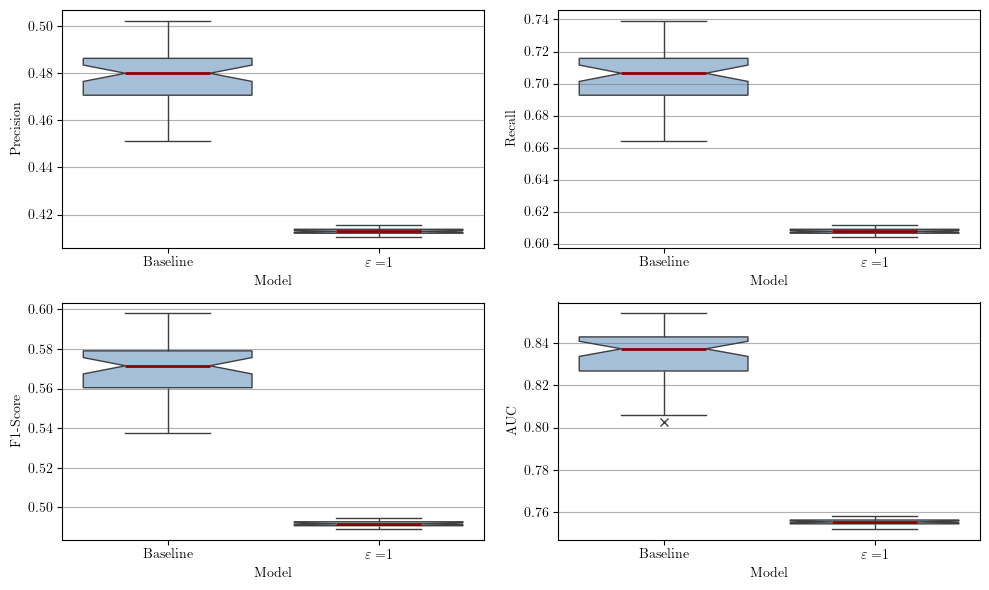

In [16]:
# Boxplot

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(perf_stats.columns.tolist()[1:]):
    ax = axes[i]
    sns.boxplot(data=perf_stats, x="Model", y=metric, ax=axes[i],
        flierprops={"marker": "x"},
        boxprops={"facecolor": (.3, .5, .7, .5)},
        medianprops={"color": "darkred", "linewidth": 2},
        notch=True, showcaps=True)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

### c. Convergence

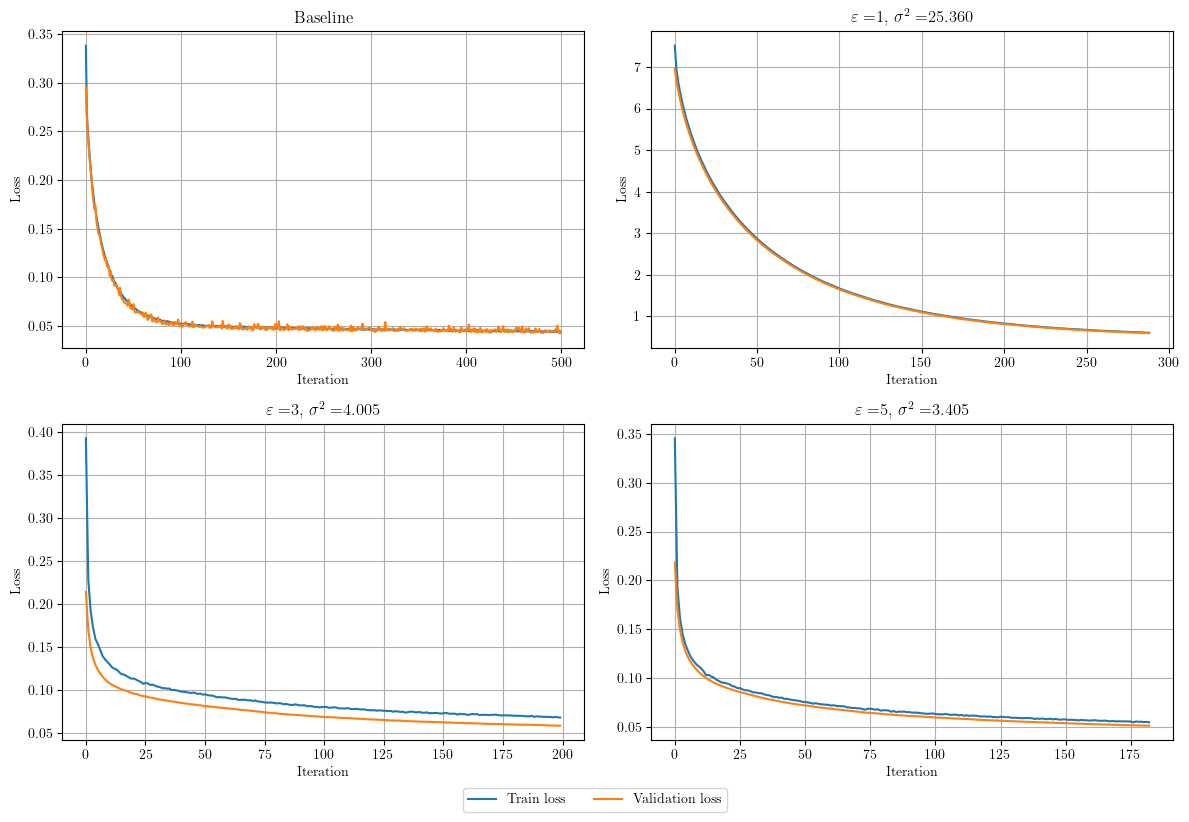

In [10]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

def plot_loss(ax, results_df, epsilon=None, noise=None):
    # Plot loss on the left y-axis
    train = ax.plot(results_df.index, results_df["train_loss"], label='Train loss')
    val = ax.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y')
    if epsilon is not None:
        ax.set_title(r"$\varepsilon =$" + f"{epsilon:.0f}" + r", $\sigma^2 =$" + f"{noise:.3f}")
    else:
        ax.set_title("Baseline")
    ax.grid(True)

    lns = train + val

    return ax, lns

ax = axes[0]
# Plot baseline performance
baseline_version = baseline_best["version"].astype(str).tolist()[0]
results_df = pd.read_csv(f"experiments/tracking/{baseline_version}_baseline.csv")
ax, lns = plot_loss(ax, results_df)

# Iterate through the rows of dpsgd_best DataFrame
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Flatten the axes for easy indexing
    ax = axes[i + 1]
    # Extract the version and epsilon from the row
    version = row["version"]
    epsilon = row["eps"]

    # Read result file
    folder = "experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)
        noise = float(file.split("noise")[-1].split(".csv")[0])

    # Plot loss
    ax, lns = plot_loss(ax, results_df, epsilon, noise)

# added these three lines
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3)

plt.tight_layout()
plt.savefig("results/figures/convergence_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
from itertools import permutations
from scipy.stats import ttest_rel

table = pd.DataFrame(np.nan, index=perf_stats["Model"].unique(), columns=perf_stats["Model"].unique())
for metric in metric_labels.values():
    if metric != "Fidelity":
        for m1, m2 in permutations(perf_stats["Model"].unique(), 2):
            if m1 != m2:
                stat, p = ttest_rel(perf_stats[perf_stats["Model"]==m1][metric], perf_stats[perf_stats["Model"]==m2][metric])
                # Convert to one-sided
                if stat > 0:
                    p_one_sided = p / 2
                else:
                    p_one_sided = 1 - (p / 2)
                table.loc[m1, m2] = f"{stat:.3f} (p = {p_one_sided:.3f})"
            else:
                table.loc[m1, m2] = "--"

print(table)

                            Baseline     $\varepsilon=$1
Baseline                         NaN  45.832 (p = 0.000)
$\varepsilon=$1  -45.832 (p = 1.000)                 NaN


### d. Summary table creation

In [11]:
# Compute fidelity
# Read the baseline predictions
baseline_predictions = pd.read_feather(f"experiments/predictions/baseline/{baseline_version}_pred.feather")
# Define a function to compute fidelity for each DP-SGD version
def get_fidelity(model_type, dpsgd_version):
    dpsgd_predictions = pd.read_feather(f"experiments/predictions/{model_type}/{dpsgd_version}_pred.feather")
    fidelity = compute_fidelity(baseline_predictions, dpsgd_predictions)
    return fidelity
# Get the fidelity of the DP-SGD models
dpsgd_best["fidelity"] = dpsgd_best["version"].apply(lambda x: get_fidelity("dpsgd", x))
metric_labels["fidelity"] = "Fidelity"
display(dpsgd_best)

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp,fidelity
108,0.742254,0.411054,0.611563,0.491651,0.755500,202506071334,1.0,0.00001,2025-06-10 03:54:53,0.710134
107,0.763114,0.438011,0.573448,0.496662,0.759364,202506070611,3.0,0.00001,2025-06-10 21:42:21,0.731169
106,0.751506,0.424439,0.615846,0.502534,0.773462,202506070329,5.0,0.00001,2025-06-10 02:53:26,0.721655


In [12]:
# Create a summary table
summary_table = pd.concat([baseline_best, dpsgd_best], ignore_index=True).set_index("eps")[["precision", "recall", "f1_score", "auc", "fidelity"]].T
# Rename the index to match the metric labels
summary_table.index = [metric_labels[metric] for metric in summary_table.index]
# Given a set of epsilon values
epsilons = {1, 3, 5}
# Create the list of tuples and set the MultiIndex
column_tuples = [("Baseline", "")] + [("DP-SGD", eps) for eps in sorted(epsilons)]
summary_table.columns = pd.MultiIndex.from_tuples(column_tuples)
summary_table.fillna("--", inplace=True)
display(summary_table)
display(summary_table["DP-SGD"][5].values[:-1]/summary_table["Baseline"].values[:-1])

# Format LaTeX rows
latex_rows = []
for idx, row in summary_table.iterrows():
    formatted = " & ".join(f"{v * 100:.3f}" if v != "--" else "--" for v in row)
    latex_rows.append(f"{idx} & {formatted} \\\\")

# Extract top-level and sub-level headers
multi_cols = summary_table.columns
top_header = [""] + [f"\\textbf{{{col[0]}}}" for col in multi_cols]
sub_header = ["\\textbf{Metric}"] + [f"\\textbf{{{col[1]}}}" if col[1] != "" else "" for col in multi_cols]

# Compose the LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{"""+ str(len(multi_cols) - 1) + r"""}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-"""+ str(1 + len(multi_cols)) + r"""}
""" + " & ".join(sub_header) + r""" \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}"""

print(latex_table)

Baseline    DP-SGD                    
                            1         3         5
Precision  0.472909  0.411054  0.438011  0.424439
Recall     0.687794  0.611563  0.573448  0.615846
F1-Score   0.560461  0.491651  0.496662  0.502534
AUC         0.81813  0.755500  0.759364  0.773462
Fidelity         --  0.710134  0.731169  0.721655

array([0.8975065464366949, 0.8953922789539228, 0.8966439193927891,
       0.9454017108162324], dtype=object)


\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{3}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-5}
\textbf{Metric} &  & \textbf{1} & \textbf{3} & \textbf{5} \\
    \midrule
Precision & 47.291 & 41.105 & 43.801 & 42.444 \\
Recall & 68.779 & 61.156 & 57.345 & 61.585 \\
F1-Score & 56.046 & 49.165 & 49.666 & 50.253 \\
AUC & 81.813 & 75.550 & 75.936 & 77.346 \\
Fidelity & -- & 71.013 & 73.117 & 72.165 \\
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}


### e. t-SNE plot

'# Draw the canvas, copy contents, and close temp\ntemp_fig = plt.figure()\ntsne = plot_tsne(0, "baseline", baseline_version)\ntemp_fig.canvas.draw()\nimage = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype=\'uint8\')\nimage = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))\nplt.close(temp_fig)\n# Show the image in the target subplot\naxes[0].imshow(image)\naxes[0].axis("off")\nfor i, row in dpsgd_best.reset_index(drop=True).iterrows():\n    # Extract the version from the row\n    version = row["version"]\n    # Plot t-SNE\n    temp_fig = plt.figure()\n    tsne = plot_tsne(i + 1, "dpsgd", version)\n    temp_fig.canvas.draw()\n    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype=\'uint8\')\n    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))\n    plt.close(temp_fig)\n    # Show the image in the target subplot\n    axes[i].imshow(image)\n    axes[i].axis("off")\n\nplt.tight_layout()\nplt.show()'

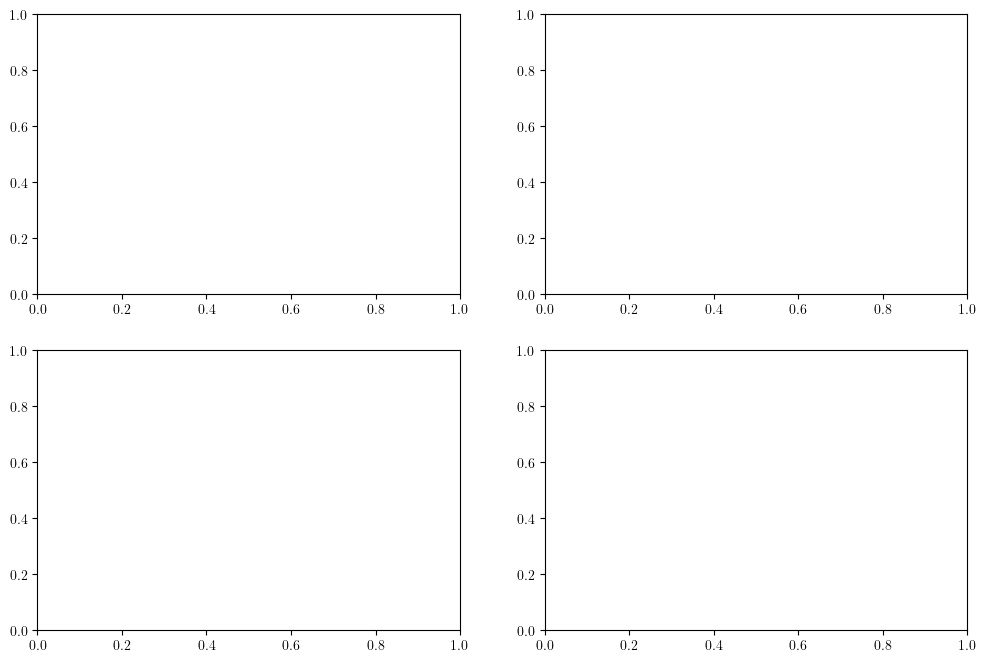

In [13]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

def plot_tsne(ax_i, model_type, version):   
    # Read the predictions
    predictions = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Read the features
    features = pd.read_feather(f"experiments/predictions/{model_type}/{version}_recons.feather")
    # Create the scatter plot
    tsne = tsne_scatter(features.values, predictions.anomaly.values, dimensions=2)
    tsne.savefig(f"results/figures/{model_type}_{version}_tsne.png", dpi=300)
    return tsne

"""# Draw the canvas, copy contents, and close temp
temp_fig = plt.figure()
tsne = plot_tsne(0, "baseline", baseline_version)
temp_fig.canvas.draw()
image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
plt.close(temp_fig)
# Show the image in the target subplot
axes[0].imshow(image)
axes[0].axis("off")
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Extract the version from the row
    version = row["version"]
    # Plot t-SNE
    temp_fig = plt.figure()
    tsne = plot_tsne(i + 1, "dpsgd", version)
    temp_fig.canvas.draw()
    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(temp_fig)
    # Show the image in the target subplot
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()"""